In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats as st
import statsmodels.stats.api as sms
from math import ceil, floor
import seaborn as sns



## Описание проблемы
Предположим, вы работаете в команде разработчиков среднего бизнеса, занимающегося электронной коммерцией. UX-дизайнер очень усердно работал над новой версией страницы продукта в надежде, что это приведет к более высокому коэффициенту конверсии. Менеджер по продукту (PM) сообщил вам, что текущий коэффициент конверсии составляет в среднем около 13% в течение года, и что команда будет рада увеличению на 2%, а это означает, что новый дизайн будет считаться успешным, если он повысит коэффициент конверсии до 15%.

Ход исследования будет содержать следующие этапы:

1) Дизайн эксперимента;

2) Сбор и подготовка данных;

3) Визуализация результатов;

4) Проверка гипотез;

5) Выработка решений, выводы

## 1. Дизайн эксперимента

### Формулирование гипотез

Прежде всего, мы хотим убедиться, что мы сформулировали гипотезу в начале нашего проекта. Это обеспечит правильную и строгую интерпретацию результатов.

Учитывая, что мы не знаем, будет ли новый дизайн работать лучше или хуже (или так же?), как наш текущий дизайн, мы выберем двусторонний тест:

Н0:р=р0
На:p≠p0

где p и p0 обозначают коэффициент конверсии нового и старого дизайна соответственно. Мы также установим уровень достоверности 95%:

α=0,05


### Определяем тестовую и контрольную группу
Для проведения эксперимента мы сформировали две группы:

**контрольная группа** ( этим пользователям будем показывать старый дизайн сайта)

**тестовая группа** (этим пользователям будет показывать новый дизайн сайта)

### Определяем размер выборки

Количество людей (или пользовательских сессий), которые мы решаем охватить в каждой группе, будет влиять на точность наших оценок коэффициентов конверсии: чем больше размер выборки, тем точнее наши оценки (т. е. чем меньше наши доверительные интервалы), тем выше шанс обнаружить разницу в двух группах, если она есть.

Размер выборки, который нам нужен, оценивается с помощью так называемого анализа мощности и зависит от нескольких факторов:

* Мощность теста ( 1−β ). Это представляет вероятность обнаружения статистической разницы между группами в нашем тесте, когда разница действительно присутствует.  
* Значение альфа (α) — критическое значение, которое мы установили ранее равным 0,05.
* MDE - минимальный ожидаемый эффект, который мы собираемся достигнуть

Поскольку наша команда была бы довольна разницей в 2%, мы можем использовать 13% и 15% для расчета ожидаемого размера эффекта.

In [3]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats as st
import statsmodels.stats.api as sms
from math import ceil, floor
import seaborn as sns




In [4]:
# Рассчитаем размер эффекта, основываясь на наших коэффициентах конверсии
effect_size = sms.proportion_effectsize(0.13,0.15)

sample_size = sms.NormalIndPower().solve_power(   # Cчитаем необходимый размер группы
    effect_size,
    power = 0.8,
    alpha = 0.05,
    ratio = 1
)

print(ceil(sample_size)) # округляем значение в большую сторону

4720


Для каждой группы мы получили необходимый размер выборки - по 4720 наблюдениц

## 2. Сбор и подготовка данных

Для нашего проекта данные будем брать с сайта Kaggle, где уже есть необходимый датасет

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/aaubs/data_science_master/main/data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
len(df)
# количество стрко в датасете

294478

In [7]:
df.shape

(294478, 5)

In [8]:
df.info()
# посмотрим общую информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [9]:
# убедимся что вся контрольная группа видит старую страницу и наоборот
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [10]:
#Видим, что некоторые пользователи в контрольной группе видят новую страницу, также как некоторые пользователи в тестовой видят старую страницу. Отфильтруем такие случаи

data = df.query('(group == "control" & landing_page == "old_page") | (group == "treatment" & landing_page == "new_page")')
pd.crosstab(data['group'], data['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


В DataFrame имеется 294478 строк, каждая из которых представляет сеанс пользователя, а также 5 столбцов:

user_id — идентификатор пользователя каждого сеанса;

timestamp — время сеанса;

группа — к какой группе был отнесен пользователь для этого сеанса (контрольная, тестовая)
Landing_page – какой дизайн каждый пользователь видел в этом сеансе (старый_дизайн, новый дизайн)
преобразовано — завершился ли сеанс преобразованием или нет (0-да, 1- нет)



Прежде чем мы продолжим выборку данных для получения нашей подгруппы, давайте удостоверимся, что нет пользователей, которые участвовали в эксперименте более одного раза, также поменяем тип данных для столбца timestamp

In [11]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       290585 non-null  int64         
 1   timestamp     290585 non-null  datetime64[ns]
 2   group         290585 non-null  object        
 3   landing_page  290585 non-null  object        
 4   converted     290585 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 13.3+ MB


<ipython-input-11-af07185a265d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamp'] = pd.to_datetime(data['timestamp'])


In [12]:
session_counts = data['user_id'].value_counts()
users_over_1 = session_counts[session_counts > 1].count()

print(f'В данных есть {users_over_1} пользователь(ей), которые участвовали в эксперименте более 1 раза')

В данных есть 1 пользователь(ей), которые участвовали в эксперименте более 1 раза


In [13]:
# Удалим из датасета пользователя, участвующего в эксперименте более 1 раза

drop_user = session_counts[session_counts > 1].index

data = data[~data['user_id'].isin(drop_user)]
print(f'Обновленный датасет содержит {len(data)} строк')

Обновленный датасет содержит 290583 строк


Теперь когда мы подготовили данные и очистили датасет от аномалий, можем продолжить определение 4720 записей для каждой из групп.

In [14]:
control_sample = data[data['group'] == "control"].sample(n = int(sample_size), random_state = 22)
test_sample = data[data['group'] == "treatment"].sample(n = int(sample_size), random_state = 22)

ab_test = pd.concat([control_sample, test_sample], axis = 0 )
ab_test.reset_index(drop=True,inplace=True)

ab_test

,user_id,timestamp,group,landing_page,converted
0,864622,2017-01-07 19:35:55.115584,control,old_page,0
1,931017,2017-01-20 22:24:11.980654,control,old_page,0
2,822759,2017-01-10 19:00:45.471182,control,old_page,0
3,715765,2017-01-19 23:16:23.269389,control,old_page,0
4,666686,2017-01-23 00:08:30.152180,control,old_page,0
...,...,...,...,...,...
9433,810221,2017-01-22 00:39:23.581340,treatment,new_page,0
9434,688017,2017-01-12 11:50:30.520706,treatment,new_page,0
9435,793361,2017-01-15 17:14:40.878898,treatment,new_page,0
9436,643157,2017-01-04 02:55:40.819424,treatment,new_page,0


In [15]:
ab_test.info() # изучим информацию о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9438 entries, 0 to 9437
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       9438 non-null   int64         
 1   timestamp     9438 non-null   datetime64[ns]
 2   group         9438 non-null   object        
 3   landing_page  9438 non-null   object        
 4   converted     9438 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 368.8+ KB


In [17]:
ab_test['group'].value_counts()

,count
group,
control,4719
treatment,4719


## 3.Визуализация результатов

In [25]:
rates_conversion = ab_test.groupby('group')['converted']
std_p = lambda x: np.std(x, ddof =0) # стандартное отклонение
std_error_p = lambda x: st.sem(x, ddof = 0) # стандартная ошибка

rates_conversion = rates_conversion.agg([np.mean, std_p, std_error_p])
rates_conversion.columns = ['conversion_rate', 'srd_deviation','std_error']

rates_conversion.style.format('{:.3f}')

<ipython-input-25-4c6f9b4bcd77>:5: FutureWarning: The provided callable <function mean at 0x7bf3e33fd5a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  rates_conversion = rates_conversion.agg([np.mean, std_p, std_error_p])


,conversion_rate,srd_deviation,std_error
group,,,
control,0.120,0.325,0.005
treatment,0.121,0.327,0.005


Судя по вышеприведенной статистике, похоже, что наши два дизайна показали очень похожие результаты, а наш новый дизайн показал немного лучшие результаты, примерно 12,3% против 12 % коэффициента конверсии.

<ipython-input-27-38335b867447>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test['group'], y = ab_test['converted'], ci = False)


Text(0, 0.5, 'Пропорция')

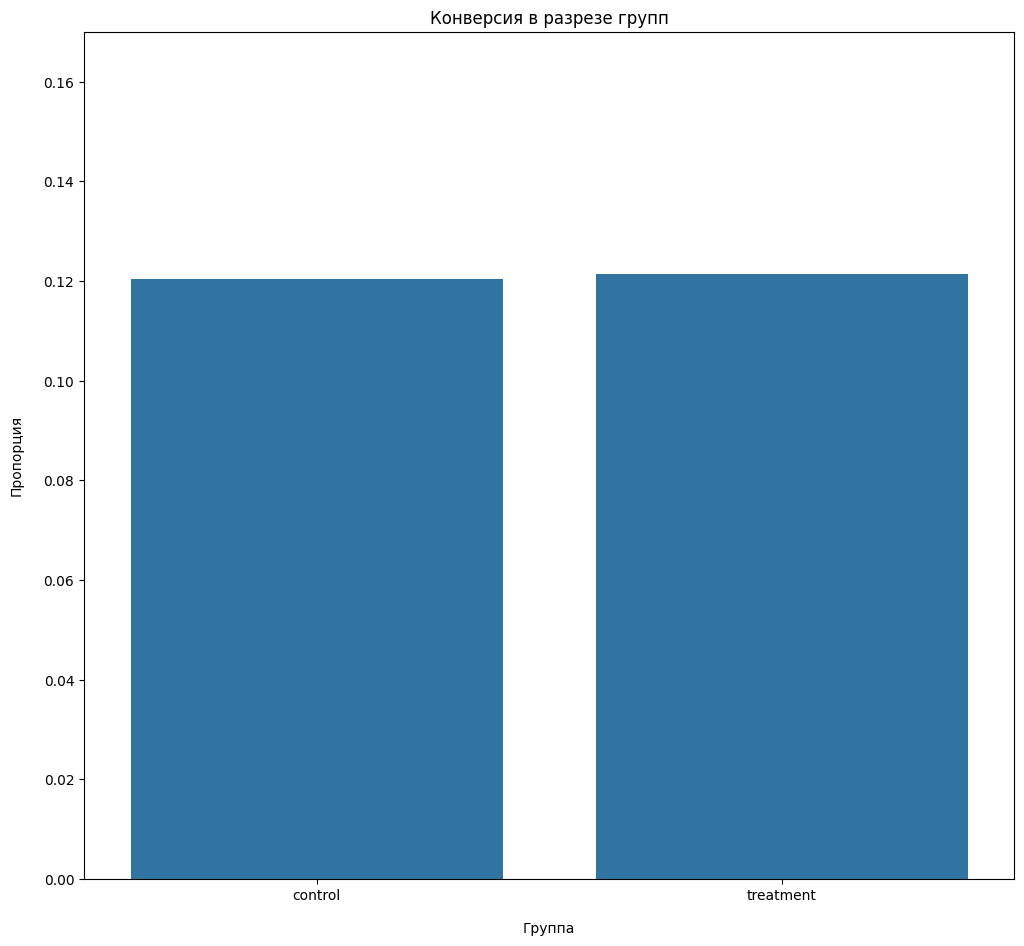

In [27]:
plt.figure(figsize=(12,11))

sns.barplot(x=ab_test['group'], y = ab_test['converted'], ci = False)

plt.ylim(0,0.17)
plt.title('Конверсия в разрезе групп')
plt.xlabel('Группа', labelpad=14)
plt.ylabel('Пропорция', labelpad=14)

<ipython-input-28-21982b4d6101>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)


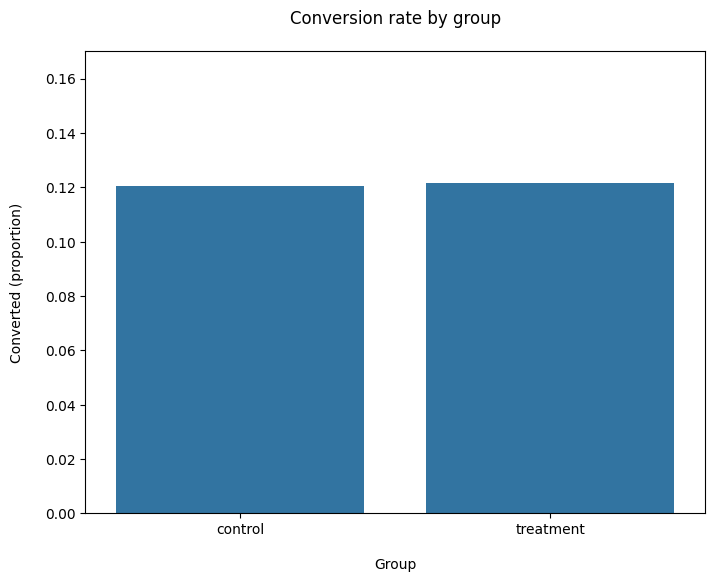

In [28]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

Как видно из графика, коэффициенты конверсии для наших групп действительно очень близки.

## 4.Проверка гипотез

Последний шаг нашего анализа — это проверка нашей гипотезы. Поскольку у нас очень большая выборка, мы можем использовать нормальное приближение для вычисления нашего p-значения (т. е. z-теста).

 Мы можем использовать модуль statsmodels.stats.proportion для получения p-значения и доверительных интервалов:

In [35]:
from statsmodels.stats.proportion  import proportions_ztest, proportion_confint

In [36]:
control_results = ab_test[ab_test['group'] == "control"]["converted"]
test_results = ab_test[ab_test['group'] == "treatment"]["converted"]

In [42]:
num_control = control_results.count()
num_test = test_results.count()
successes_observ = [control_results.sum(), test_results.sum()]
num_obs = [num_control, num_test]

z_stat, pvalue = proportions_ztest(successes_observ,num_obs)

(lower_control, lower_test), (upper_control, upper_test) = proportion_confint(successes_observ,num_obs, alpha = 0.05)




In [47]:
print(f'Z_statisctic: {z_stat:.2f}')
print(f'Pvalue: {pvalue:.3f}')
print(f'ci 95% for control group: [{lower_control:.3f}, {upper_control:.3f}]')
print(f'ci 95% for test group: [{lower_test:.3f}, {upper_test:.3f}]')

Z_statisctic: -0.16
Pvalue: 0.875
ci 95% for control group: [0.111, 0.130]
ci 95% for test group: [0.112, 0.131]


## 5. Выработка решений,выводы

Поскольку наше p-значение = 0,875 намного выше нашего α = 0,05, мы не можем отвергнуть нулевую гипотезу H0, что означает, что наш новый дизайн не показал существенно иных результатов (не говоря уже о том, чтобы быть лучше), чем наш старый.

Кроме того, если мы посмотрим на доверительный интервал для тествоой группы  ([0,112, 0,131], т. е. 11,2–13,1%), мы заметим, что:

Он включает наше базовое значение коэффициента конверсии 13%
Он не включает наше целевое значение 15% (2%-ный подъем, к которому мы стремились)
Это означает, что более вероятно, что истинный коэффициент конверсии нового дизайна будет аналогичен нашему базовому значению, а не целевому показателю 15%, на который мы надеялись.

Таким образом, результаты A/B теста позволяют сделать вывод о том, что новый дизайн сайта не принесет улучшения в плане увеличения конверсии, а значит, можно признать результаты A/B теста неудовлетворительными.

